In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


# Load and Preprocess Dataset

In [ ]:
import os

data_dir = '/content/drive/MyDrive/flowers'


In [ ]:
print("Classes inside flowers directory:")
print(os.listdir(data_dir))

Classes inside flowers directory:
['tulip', 'sunflower', 'rose', 'dandelion', 'daisy', 'model3.keras', 'model4.keras']


In [ ]:
batch_size = 32
img_size = (224, 224)

# Splitting the data into training and validation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Flower categories:", class_names)


Flower categories: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
print(f"Train size: {len(train_ds)} batches")
print(f"Val size: {len(val_ds)} batches")


Train size: 108 batches
Val size: 27 batches


In [ ]:
train_count = 0
for _ in train_ds:
    train_count += 1
print(f"Train batches: {train_count}")


Train batches: 108


# **AUTOTUNE and prefetch()**

# tf.data.AUTOTUNE:

Lets TensorFlow automatically decide how much data to prefetch for best performance.

# prefetch():

Loads the next batch while the current one is being processed, reducing GPU/TPU idle time.

# Why it's useful:
Makes training faster by overlapping data loading and model execution.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


# Data Argumentation
It is a preprocessing layer (built using tf.keras.Sequential) that applies random transformations to training images, such as flipping, rotating, zooming, etc.

.To artificially increase dataset variety and help the model generalize better — by showing it slightly altered versions of the same image.

In [ ]:
from tensorflow.keras import layers


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])


weights='imagenet': loads pretrained weights.

include_top=False: removes the original classifier (so we can add our own).

trainable = False: freezes all layers of VGG16 so we only train the new classifier part.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


Input → Augment → Preprocess → VGG16 → Pool → Dropout → Dense(5)

Dropout(0.2) helps reduce overfitting

Dense(5) because you have 5 flower classes (daisy, dandelion, etc.)

# Model1

VGG16 ACHITECTURE

Input: (224, 224, 3)

Block 1:
- Conv2D (64 filters, 3x3) + ReLU
- Conv2D (64 filters, 3x3) + ReLU
- MaxPooling2D (2x2)

Block 2:
- Conv2D (128 filters, 3x3) + ReLU
- Conv2D (128 filters, 3x3) + ReLU
- MaxPooling2D (2x2)

Block 3:
- Conv2D (256 filters, 3x3) + ReLU
- Conv2D (256 filters, 3x3) + ReLU
- Conv2D (256 filters, 3x3) + ReLU
- MaxPooling2D (2x2)

Block 4:
- Conv2D (512 filters, 3x3) + ReLU
- Conv2D (512 filters, 3x3) + ReLU
- Conv2D (512 filters, 3x3) + ReLU
- MaxPooling2D (2x2)

Block 5:
- Conv2D (512 filters, 3x3) + ReLU
- Conv2D (512 filters, 3x3) + ReLU
- Conv2D (512 filters, 3x3) + ReLU
- MaxPooling2D (2x2)

Output: Feature map (7, 7, 512)

16 weight layers (13 convolutional layers + 3 fully connected layers)

Input size: 224x224x3 (RGB images)

Uses only 3x3 convolution filters with stride 1 and 2x2 max-pooling with stride 2.

Ends with 2 FC (fully connected) layers of 4096 units, and 1 output FC layer.

In [ ]:
from tensorflow.keras import Model, layers

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model1= Model(inputs, outputs)


In [ ]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │      2,565 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,722,385 (56.16 MB)

 Trainable params: 7,081,989 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 5,132 (20.05 KB)

Compile the model

In [ ]:
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop_cb = EarlyStopping(monitor="val_accuracy",
                             patience=10,
                             verbose=1,
                             restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint("model1.keras",
                                verbose=1,
                                save_best_only=True,
                                monitor="val_accuracy",
                                mode="max"
)



In [ ]:
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3814 - loss: 3.3850
Epoch 1: val_accuracy improved from -inf to 0.67555, saving model to model1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 698s 6s/step - accuracy: 0.3824 - loss: 3.3759 - val_accuracy: 0.6756 - val_loss: 1.1613
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6487 - loss: 1.3425
Epoch 2: val_accuracy improved from 0.67555 to 0.77636, saving model to model1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 69s 213ms/step - accuracy: 0.6488 - loss: 1.3413 - val_accuracy: 0.7764 - val_loss: 0.7997
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7069 - loss: 1.0031
Epoch 3: val_accuracy improved from 0.77636 to 0.80997, saving model to model1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.7071 - loss: 1.0027 - val_accuracy: 0.8100 - val_loss: 0.6365
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7572 - loss: 0.8058
Epoch 4: val_accuracy improved from 0.809

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")


In [ ]:
loss, accuracy =model1.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8748 - loss: 0.3812
Validation Accuracy: 86.44%


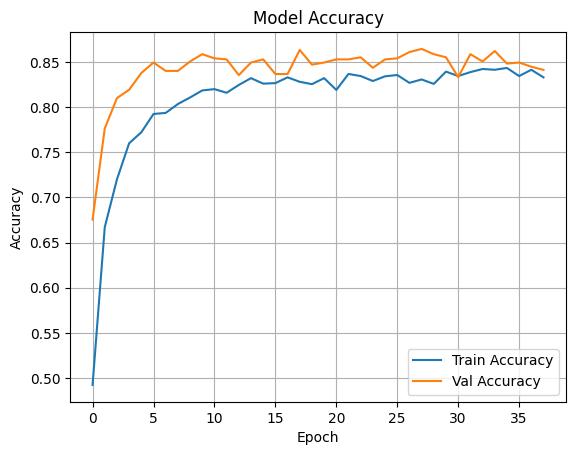

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



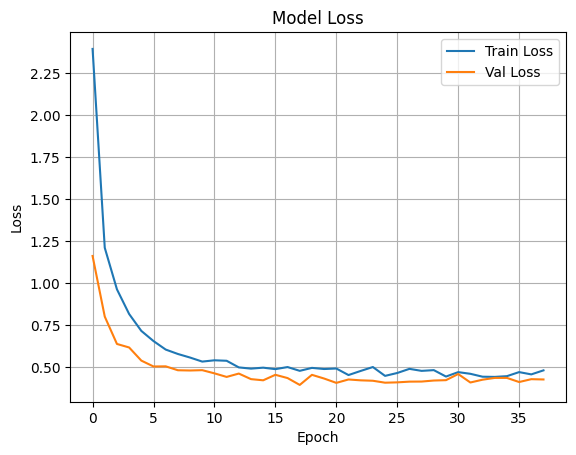

In [ ]:
# Loss plot
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_hat1 = model1.predict(val_ds)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step


In [ ]:
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


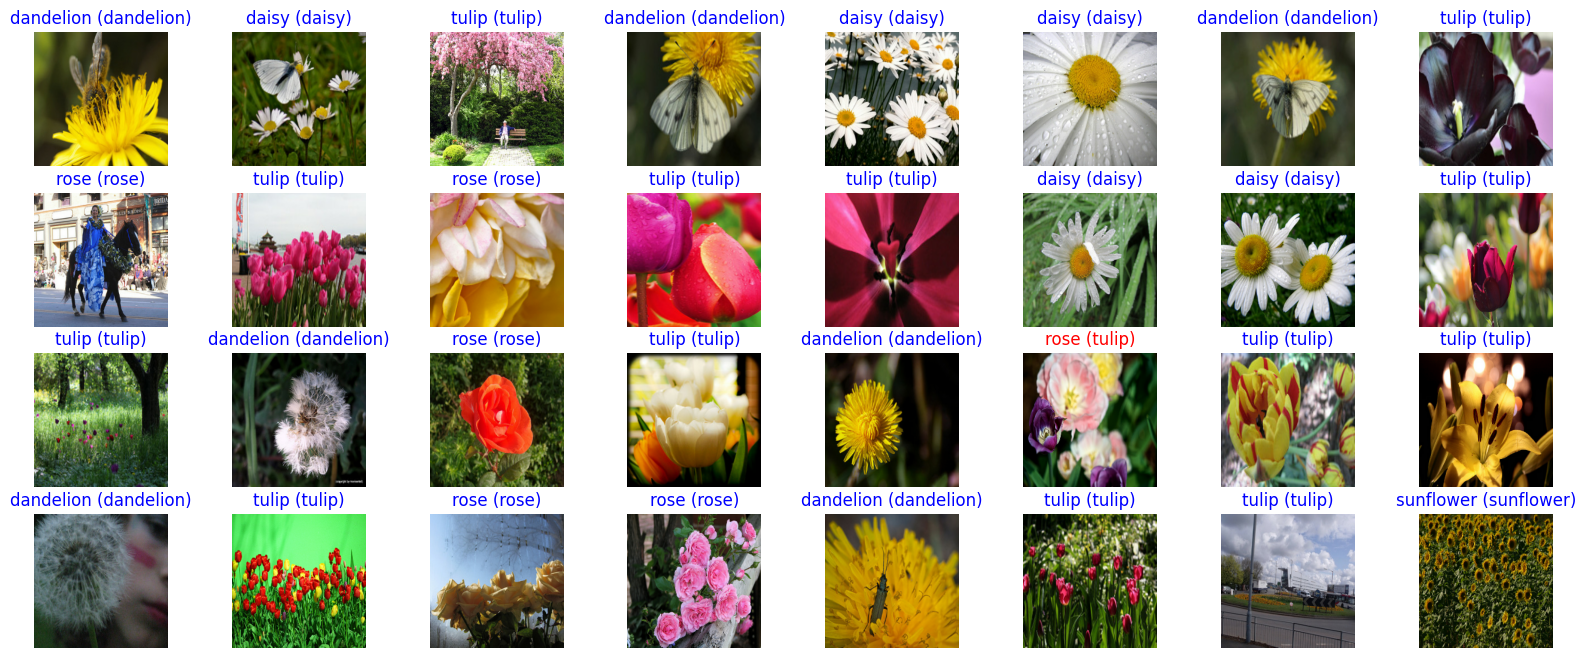

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of images and labels from val_ds
for images, labels in val_ds.take(1):  # just one batch
    preds = model1.predict(images)
    preds_idx = np.argmax(preds, axis=1)
    true_idx = labels.numpy()

    plt.figure(figsize=(20, 8))
    for i in range(32):  # Show first 32 images
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
        ax.set_title(
            "{} ({})".format(
                flower_labels[preds_idx[i]], flower_labels[true_idx[i]]
            ),
            color="blue" if preds_idx[i] == true_idx[i] else "red"
        )


# Model2     


Unfreeze part of VGG16

In [ ]:
# Unfreeze last few layers of VGG16 for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False


In [ ]:
from tensorflow.keras import layers, models, optimizers

model2 = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,072,465 (110.90 MB)

 Trainable params: 7,145,733 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,291,468 (54.52 MB)

In [ ]:
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop_2 = EarlyStopping(monitor="val_accuracy",
                             patience=10,
                             verbose=1,
                             restore_best_weights=True
)

checkpoint_2 = ModelCheckpoint("model2.keras",
                                verbose=1,
                                save_best_only=True,
                                monitor="val_accuracy",
                                mode="max"
)



In [ ]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_2, earlystop_2]
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.3222 - loss: 3.1609
Epoch 1: val_accuracy improved from -inf to 0.57010, saving model to model2.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step - accuracy: 0.3226 - loss: 3.1512 - val_accuracy: 0.5701 - val_loss: 1.1611
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5526 - loss: 1.1493
Epoch 2: val_accuracy improved from 0.57010 to 0.71611, saving model to model2.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step - accuracy: 0.5530 - loss: 1.1485 - val_accuracy: 0.7161 - val_loss: 0.7802
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6513 - loss: 0.9094
Epoch 3: val_accuracy improved from 0.71611 to 0.78911, saving model to model2.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.6516 - loss: 0.9088 - val_accuracy: 0.7891 - val_loss: 0.6247
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7308 - loss: 0.7273
Epoch 4: val_accuracy improved from 

In [ ]:
loss, accuracy =model2.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9443 - loss: 0.2198
Validation Accuracy: 92.47%


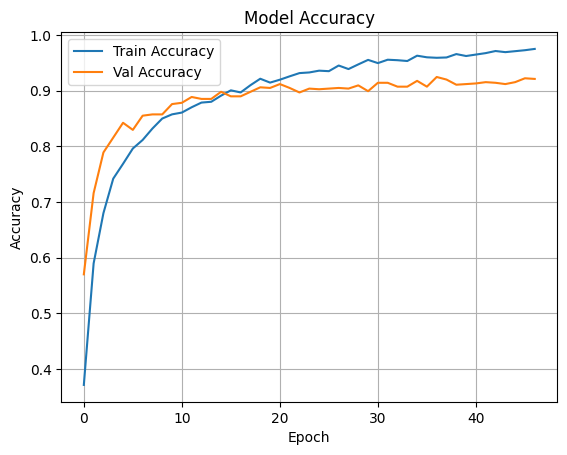

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



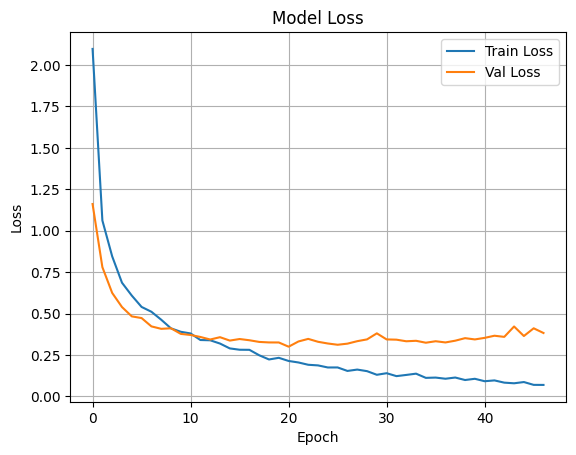

In [ ]:
# Loss plot
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_hat2 = model2.predict(val_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step


In [ ]:
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


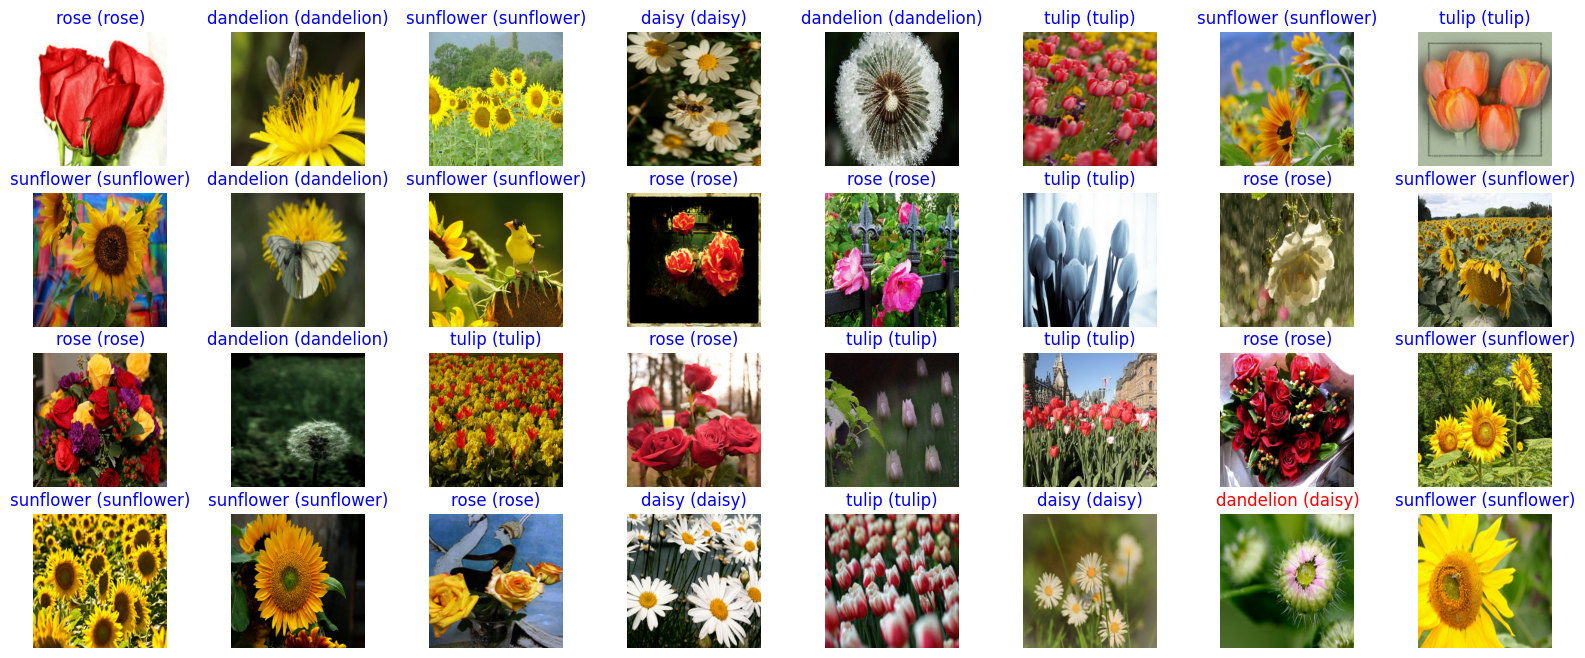

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of images and labels from val_ds
for images, labels in val_ds.take(1):
    preds = model2.predict(images)
    preds_idx = np.argmax(preds, axis=1)
    true_idx = labels.numpy()

    plt.figure(figsize=(20, 8))
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
        ax.set_title(
            "{} ({})".format(
                flower_labels[preds_idx[i]], flower_labels[true_idx[i]]
            ),
            color="blue" if preds_idx[i] == true_idx[i] else "red"
        )


# Model 3 with   EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


Load Base Model (Without Top)

In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze weights for now


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras import layers, models

model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),                      # Dropout to reduce overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')     # 5 flower classes
])


In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,543,412 (17.33 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 329,228 (1.26 MB)

In [ ]:
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop3 = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint3 = ModelCheckpoint(
    'model3.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop3, checkpoint3],
    verbose=1
)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6960 - loss: 0.7712
Epoch 1: val_accuracy improved from -inf to 0.91194, saving model to model3.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 76s 456ms/step - accuracy: 0.6969 - loss: 0.7690 - val_accuracy: 0.9119 - val_loss: 0.2591
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8921 - loss: 0.2970
Epoch 2: val_accuracy did not improve from 0.91194
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - accuracy: 0.8921 - loss: 0.2969 - val_accuracy: 0.8980 - val_loss: 0.2613
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9158 - loss: 0.2398
Epoch 3: val_accuracy did not improve from 0.91194
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9157 - loss: 0.2398 - val_accuracy: 0.9108 - val_loss: 0.2432
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9285 - loss: 0.1987
Epoch 4: val_accuracy improved from 0.91194 to 0.92236, saving model to model3.keras
108/108 ━━━━━━━━━━━

In [ ]:
loss, accuracy =model3.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9482 - loss: 0.1537
Validation Accuracy: 93.28%


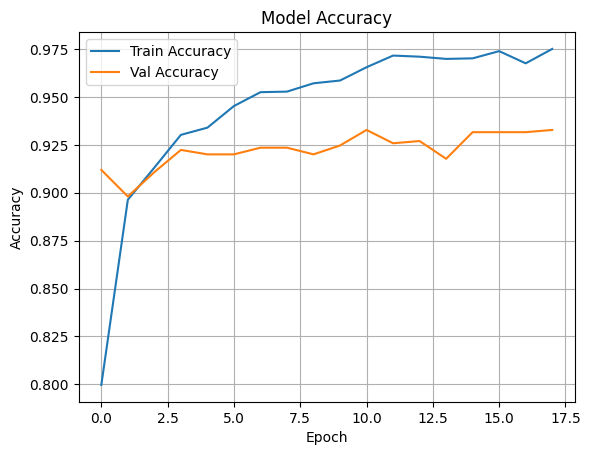

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



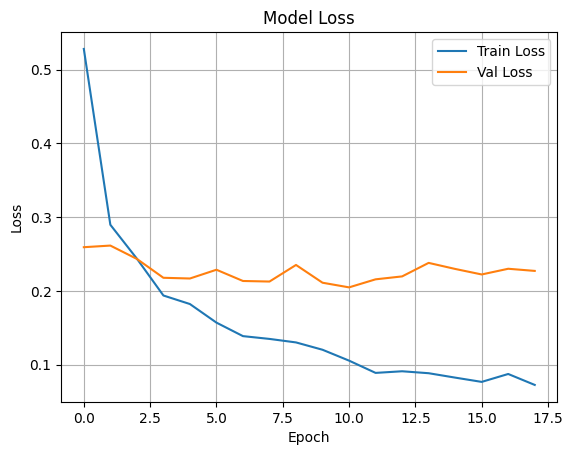

In [ ]:
# Loss plot
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_hat3 = model3.predict(val_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step


In [ ]:
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


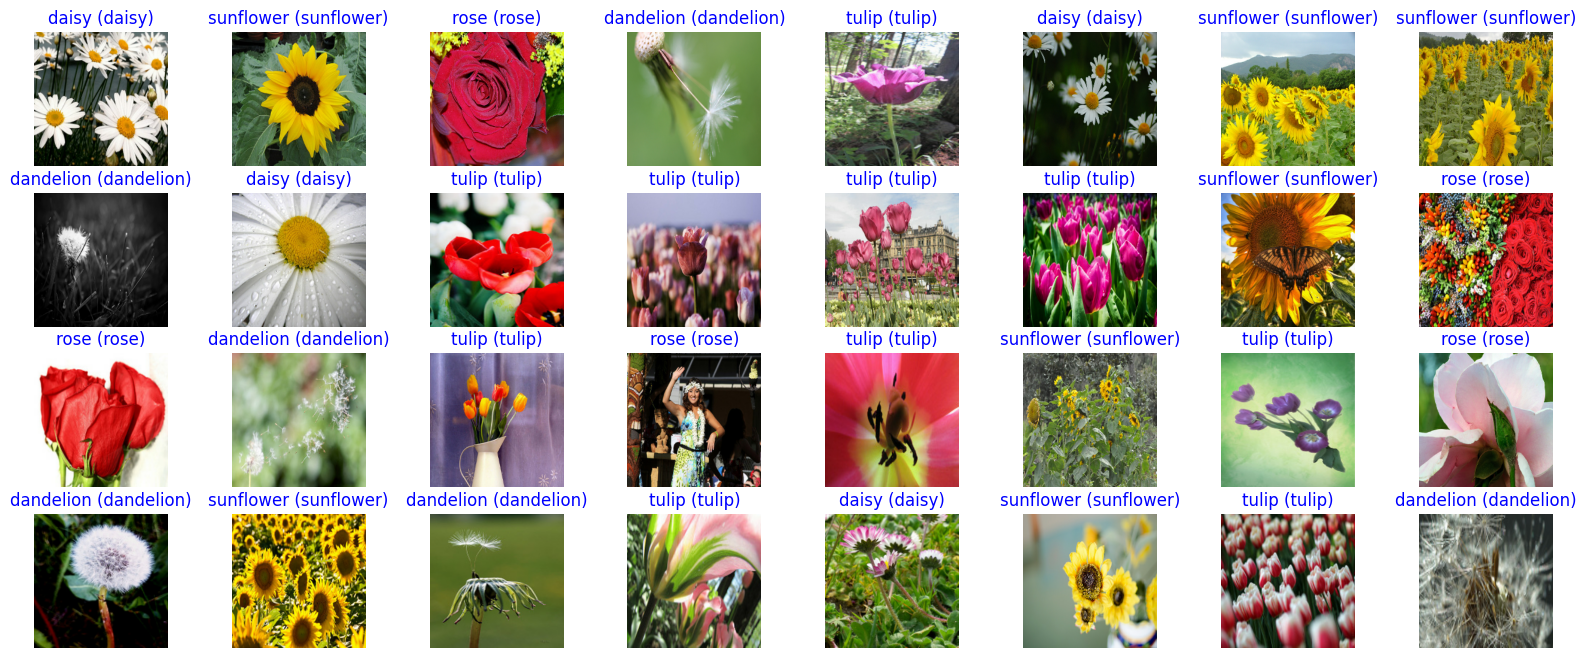

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of images and labels from val_ds
for images, labels in val_ds.take(1):
    preds = model3.predict(images)
    preds_idx = np.argmax(preds, axis=1)
    true_idx = labels.numpy()

    plt.figure(figsize=(20, 8))
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
        ax.set_title(
            "{} ({})".format(
                flower_labels[preds_idx[i]], flower_labels[true_idx[i]]
            ),
            color="blue" if preds_idx[i] == true_idx[i] else "red"
        )


🚀 Option: Try a pretrained model like:

Model	Pros	Cons

ResNet50	Powerful, deep, good generalization	Slower to train, more complex

MobileNetV2	Light, fast, great on edge devices	Slightly less accurate than ResNet

EfficientNetB0	Best mix of accuracy & efficiency	Newer, a bit slower to train

# Model 4:  using ResNet

# ResNet-50 Architecture:

1 Conv layer

16 Bottleneck blocks (each with 3 layers inside)

Total: 50 layers (Conv + BN + ReLU + FC counted)

🔍 Layer Breakdown:
Stage	Output Size	Layers
Conv1	112×112	7×7 Conv, 64, stride 2 + 3×3 MaxPool, stride 2

Conv2_x	56×56	1×1, 64 → 3×3, 64 → 1×1, 256 × 3 blocks

Conv3_x	28×28	1×1, 128 → 3×3, 128 → 1×1, 512 × 4 blocks

Conv4_x	14×14	1×1, 256 → 3×3, 256 → 1×1, 1024 × 6 blocks

Conv5_x	7×7	1×1, 512 → 3×3, 512 → 1×1, 2048 × 3 blocks

AvgPool	1×1	Global Average Pooling

FC	1×1×1000	Fully Connected (Softmax for classification)



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
# Define augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(0.1, 0.1)
])

In [ ]:
inputs = Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model4 = Model(inputs=inputs, outputs=output)


In [ ]:
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ sequential_3[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c

 Total params: 24,147,333 (92.11 MB)

 Trainable params: 17,509,381 (66.79 MB)

 Non-trainable params: 6,637,952 (25.32 MB)

In [ ]:
model4.compile(optimizer=Adam(learning_rate=5e-5),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop_4 = EarlyStopping(monitor="val_accuracy",
                             patience=10,
                             verbose=1,
                             restore_best_weights=True
)

checkpoint_4 = ModelCheckpoint("model4.keras",
                                verbose=1,
                                save_best_only=True,
                                monitor="val_accuracy",
                                mode="max"
)



In [ ]:
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[earlystop_4, checkpoint_4],
    verbose=1
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3093 - loss: 2.2972
Epoch 1: val_accuracy improved from -inf to 0.69988, saving model to model4.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 61s 335ms/step - accuracy: 0.3103 - loss: 2.2931 - val_accuracy: 0.6999 - val_loss: 0.8139
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6085 - loss: 1.1444
Epoch 2: val_accuracy improved from 0.69988 to 0.82851, saving model to model4.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - accuracy: 0.6088 - loss: 1.1433 - val_accuracy: 0.8285 - val_loss: 0.5061
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7178 - loss: 0.8093
Epoch 3: val_accuracy improved from 0.82851 to 0.87138, saving model to model4.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.7179 - loss: 0.8090 - val_accuracy: 0.8714 - val_loss: 0.3979
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7691 - loss: 0.6591
Epoch 4: val_accuracy improved from 

In [ ]:
loss, accuracy =model4.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9435 - loss: 0.2706
Validation Accuracy: 93.63%


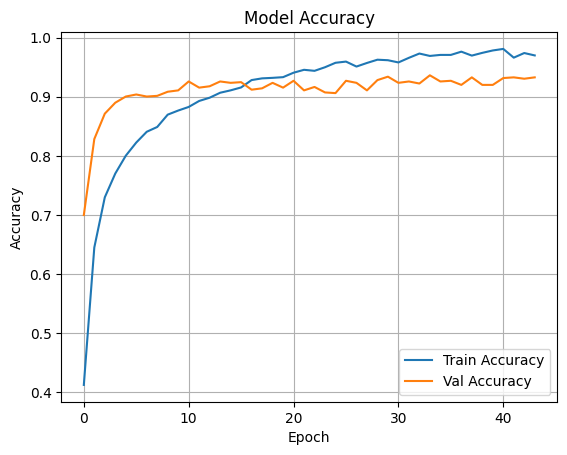

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


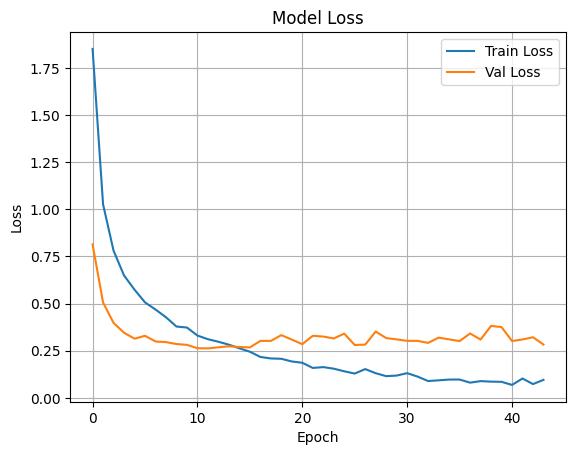

In [ ]:
# Loss plot
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_hat4 = model4.predict(val_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step


In [ ]:
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


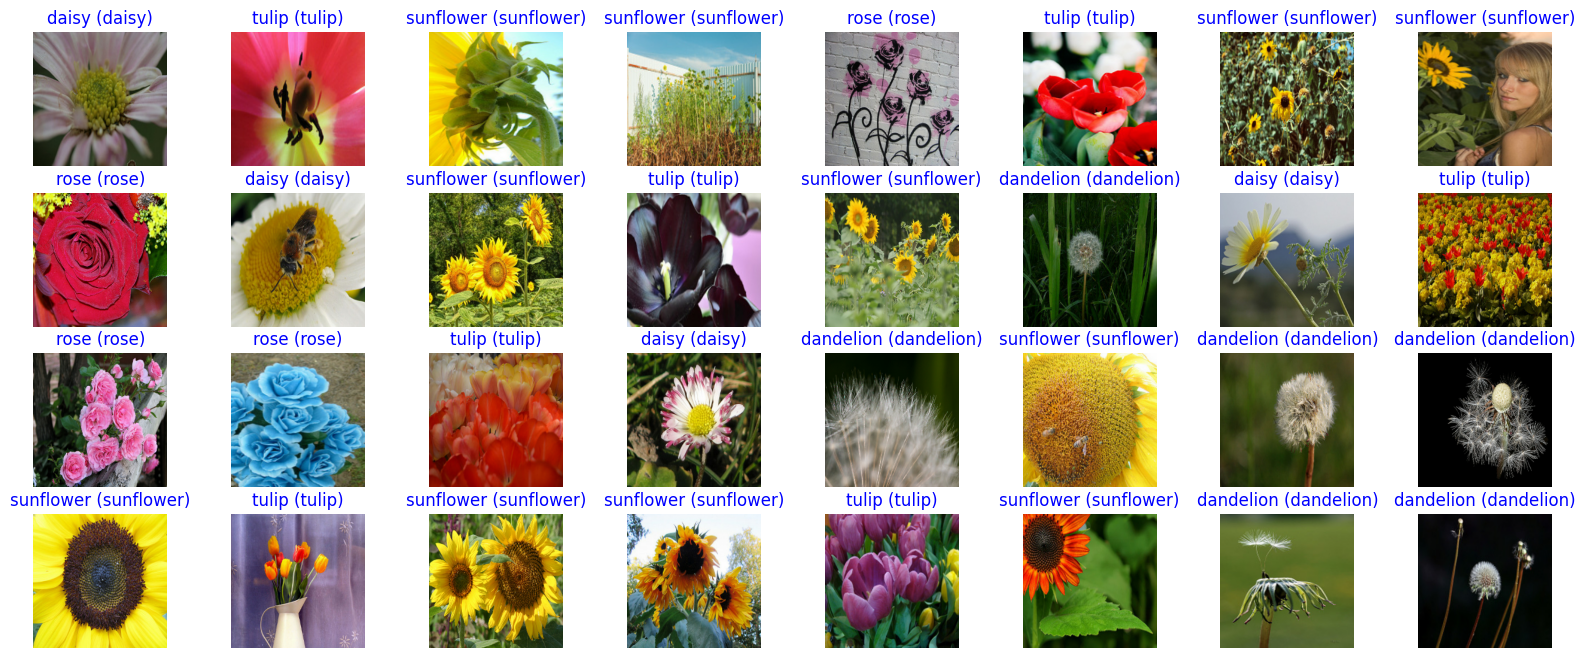

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of images and labels from val_ds
for images, labels in val_ds.take(1):
    preds = model4.predict(images)
    preds_idx = np.argmax(preds, axis=1)
    true_idx = labels.numpy()

    plt.figure(figsize=(20, 8))
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
        ax.set_title(
            "{} ({})".format(
                flower_labels[preds_idx[i]], flower_labels[true_idx[i]]
            ),
            color="blue" if preds_idx[i] == true_idx[i] else "red"
        )


In [ ]:
model3.save("model3_final", save_format='tf')
model4.save("model4_final", save_format='tf')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/model3.keras")

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model("/content/model4(old).keras")

Checking Model4 With google Images


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow

In [ ]:
flower_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: daisy


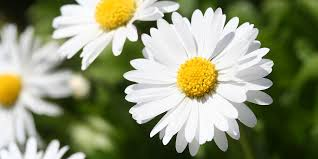

In [ ]:
img_path = '/content/dasies.jpg'
img = load_img(img_path, target_size=(224, 224))
arr = img_to_array(img)
arr_input = np.expand_dims(arr / 255.0, axis=0)


pred = model.predict(arr_input)
cls = np.argmax(pred[0])
print("Predicted class:", flower_labels[cls])

original_img = cv2.imread(img_path)
cv2_imshow(original_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: rose


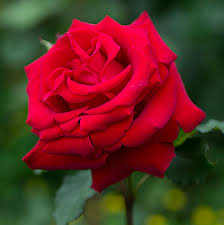

In [ ]:
img_path2 = '/content/rose.jpg'
img2 = load_img(img_path2, target_size=(224, 224))
arr2 = img_to_array(img2)
arr2_input = np.expand_dims(arr2 / 255.0, axis=0)

pred2 = model2.predict(arr2_input)
cls2 = np.argmax(pred2[0])

print("Predicted class:", flower_labels[cls2])

original_img2 = cv2.imread(img_path2)
cv2_imshow(original_img2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class: daisy


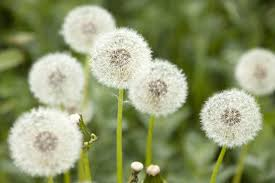

In [ ]:
img_path3 = '/content/dend.jpg'
img3 = load_img(img_path3, target_size=(224, 224))
arr3 = img_to_array(img3)
arr3_input = np.expand_dims(arr3 / 255.0, axis=0)

pred3 = model2.predict(arr3_input)
cls3 = np.argmax(pred3[0])

print("Predicted class:", flower_labels[cls3])

original_img3 = cv2.imread(img_path3)
cv2_imshow(original_img3)


In [ ]:
print("Raw model prediction:", pred3[0])


Raw model prediction: [0.33310106 0.08262549 0.273035   0.07049674 0.24074174]
